In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from pathlib import Path
import glob
import os
import cv2


2024-08-21 16:11:56.373983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 16:11:56.374046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 16:11:56.375598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# import zipfile
# with zipfile.ZipFile("/kaggle/input/teeth-data", 'r') as zip_ref:
#     zip_ref.extractall()

In [3]:
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU device: {}' .format(tf.test.gpu_device_name()))

Default GPU device: /device:GPU:0


In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)


    return images

In [5]:
def data(folders):
    imgs = []
    labels = []
    names = []
    for folder in folders:
        for img in load_images_from_folder(folder):
            imgs.append(img)

            if 'CaS' in folder:
                labels.append('CaS')
            elif 'CoS' in folder:
                labels.append('CoS')
            elif 'Gum' in folder:
                labels.append('Gum')
            elif 'MC' in folder:
                labels.append('MC')
            elif 'OC' in folder:
                labels.append('OC')
            elif 'OLP' in folder:
                labels.append('OLP')
            elif 'OT' in folder:
                labels.append('OT')
            else:
                print("error")

        for name in os.listdir(folder):
            names.append(os.path.join(folder, name))

    names = pd.Series(names, name= 'name')
    imgs = pd.Series(imgs, name='image', dtype= np.float32)
    labels = pd.Series(labels, name="label")

    image_df = pd.concat([names, imgs, labels], axis=1)

    return image_df


In [6]:
path = "/kaggle/input/teeth-data/data/Teeth_Dataset/Training"
folders = [os.path.join(path, x) for x in os.listdir(path)]
train_df = data(folders)

In [7]:
path = "/kaggle/input/teeth-data/data/Teeth_Dataset/Testing"
folders = [os.path.join(path, x) for x in os.listdir(path)]
test_df = data(folders)

In [8]:
path = "/kaggle/input/teeth-data/data/Teeth_Dataset/Validation"
folders = [os.path.join(path, x) for x in os.listdir(path)]
validation_df = data(folders)

# Visulaization

In [9]:
label_counts = train_df["label"].value_counts()

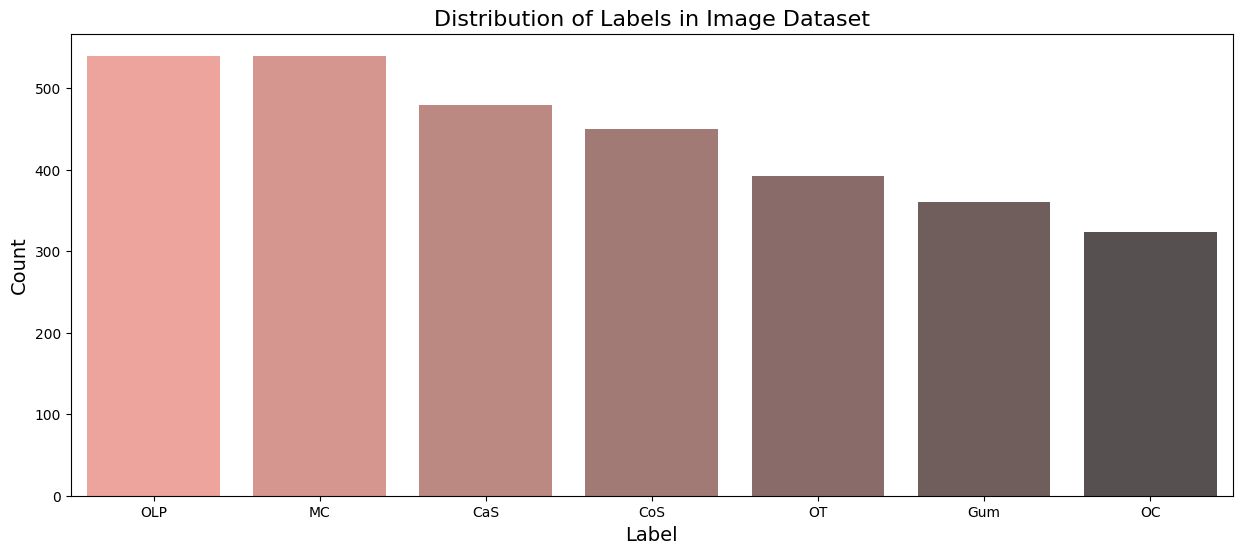

In [10]:
plt.figure(figsize=(15, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='dark:salmon_r')

plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

<Figure size 2000x1000 with 0 Axes>

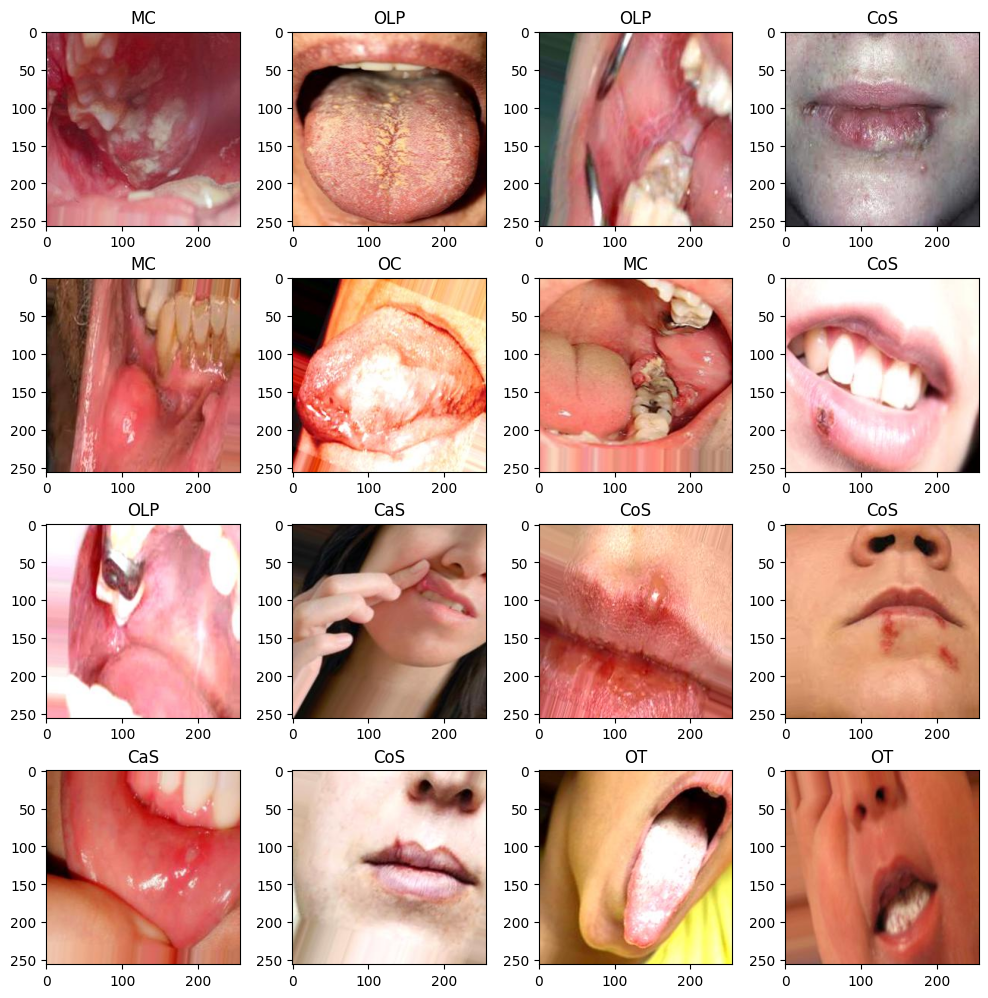

In [11]:
plt.figure(figsize= (20, 10))
random_values = np.random.randint(0, len(train_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (10, 10))

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.name[random_values[i]]))
    ax.set_title(train_df.label[random_values[i]])
    plt.tight_layout()
plt.show()

# PreProcessing

In [12]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [13]:
train_path = train_df.pop("name").astype(str)
valid_path = validation_df.pop("name").astype(str)
train_path = test_df.pop("name").astype(str)



In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/teeth-data/data/Teeth_Dataset/Training",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = train_datagen.flow_from_directory(
    "/kaggle/input/teeth-data/data/Teeth_Dataset/Validation",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_datagen_generator = train_datagen.flow_from_directory(
    "/kaggle/input/teeth-data/data/Teeth_Dataset/Testing",
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


# Training

In [15]:
input_shape = [224, 224, 3]

model = tf.keras.Sequential([

    layers.Conv2D(filters= 64, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
    layers.MaxPool2D(pool_size=(2,2), strides= 2),
    layers.Conv2D(filters= 128, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
    layers.MaxPool2D(pool_size=(2,2), strides= 2),
    layers.Conv2D(filters= 256, kernel_size= (3,3), activation= "relu", input_shape= input_shape ),
    layers.MaxPool2D(pool_size=(2,2), strides= 2),

    layers.Flatten(),
    layers.Dense(units= 1000, activation= "relu"),
    layers.Dropout(.5),
    layers.Dense(units= 200, activation= "relu"),


    layers.Dense(7, activation= "softmax")


])



Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device 

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │   173,057,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 173,629,423 (662.34 MB)

 Trainable params: 173,629,423 (662.34 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer= keras.optimizers.Adamax(learning_rate=.0001),
    loss = "categorical_crossentropy",
    metrics= ["accuracy"]
)

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
_Retval): /job:localhost/replica:0/task:0/device:GPU:0
VarHandleOp: (VarHandleOp): /job:localhost/replica:0/task:0/device:GPU:0
resource: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
value: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
AssignVariableOp: (AssignVariableOp): /job:localhost/replica:0/task:0/device:GPU:0
resource_RetVal: (_Retv

In [20]:
model = keras.models.load_model("/kaggle/input/teeth_model_from_scratch/keras/default/1/model_checkpoint.keras")

Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhos

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 173056)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │   173,057,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       200,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         1,407 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,888,271 (1.94 GB)

 Trainable params: 173,629,423 (662.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 347,258,848 (1.29 GB)

In [21]:
results = model.evaluate(test_datagen_generator , verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0


I0000 00:00:1724256827.774173     400 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724256827.792404     400 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_one_step_on_iterator_

W0000 00:00:1724256840.762549     401 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Training

In [24]:
# Create checkpoint callback
checkpoint_path = "model_checkpoint.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [29]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data= valid_generator,
    verbose=1, 
    callbacks=[
        early_stopping,
        checkpoint_callback,
        reduce_lr
    ]
 )

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DummySeedGenerator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ShuffleDatasetV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/10
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_iterator_2559 in devic

KeyboardInterrupt: 

# Evaluation

In [25]:
results = model.evaluate(test_datagen_generator , verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AnonymousIteratorV3 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MakeIterator in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_one_step_on_iterator_1177 in device /job:localhost/replica:0/task:0/device:GPU:0
evice:GPU:0
unknown_7: (_Arg): /job:localhost/replica:0/task:0/device:GPU:0
unknown_8: (_Arg): /job:localhost/replica:0/task:0/device:GP

In [24]:
# accuracy = history.history['accuracy']
# val_accuracy = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(accuracy))
# plt.plot(epochs, accuracy, 'b', label='Training accuracy')
# plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')

# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

# TRASH

In [ ]:
# path = "Teeth_Dataset/Training/"
# labels = os.listdir(path)
# folders = [os.path.join(path, x) for x in os.listdir(path)]

# print(labels)

# all_images = [img for folder in folders for img in load_images_from_folder(folder)]
# all_labels = [lab for folder in folders for lab in load_labels_from_folder(folder)]



In [ ]:
# train_batch = datagen.flow_from_dataframe(
#     dataframe = train_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed= 42,
#     subset='training',

# )

# valid_batch = generator.flow_from_dataframe(
#     dataframe = validation_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed= 42,
#     subset='training'
# )

# test_batch = generator.flow_from_dataframe(
#     dataframe = test_df,
#     x_col = 'image',
#     y_col = 'label',
#     target_size = TARGET_SIZE,
#     class_mode='categorical',
#     batch_size=BATCH_SIZE,
#     shuffle= False,
#     subset='training'
# )





# train_generator = train_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Training",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

# val_generator = val_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Validation",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

# test_generator = test_datagen.flow_from_directory(
#     "/content/Teeth_Dataset/Testing",
#     target_size=TARGET_SIZE,
#     batch_size=BATCH_SIZE,
#     class_mode='categorical'
# )

In [ ]:
# train_size = len(train_dataset)
# validation_size = len(validation_dataset)

# train_steps = int(len(train_dataset) / BATCH_SIZE)
# validation_steps = int(len(validation_dataset) /  BATCH_SIZE)


In [ ]:
# augment = tf.keras.Sequential([
#   layers.Resizing(224,224, 3),
#   layers.Rescaling(1./255),
#   layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.1),
#   layers.RandomZoom(0.1),
#   layers.RandomContrast(0.1)
# ])



In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     validation_data=valid_generator ,
#     validation_steps=len(valid_generator),
#     epochs=100,
#     callbacks=[
#         early_stopping,
#         keras.callbacks.TensorBoard("training_logs", 
#                                     "bird_classification"),
#         checkpoint_callback,
#         reduce_lr
#     ]
# )